In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

2023-10-28 15:43:18.928494: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPUs


In [3]:
tf.__version__

'2.10.0'

In [4]:
import urllib.request
if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py", "lab11_1_lib.py")

from lab11_1_lib import draw_timeline

In [5]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/bald_eagle
oregon_wildlife/black_bear
oregon_wildlife/cougar
oregon_wildlife/deer
oregon_wildlife/nutria
oregon_wildlife/raccoon
oregon_wildlife/raven
oregon_wildlife/red_fox
oregon_wildlife/sea_lions
oregon_wildlife/virginia_opossum

total img num: 7168


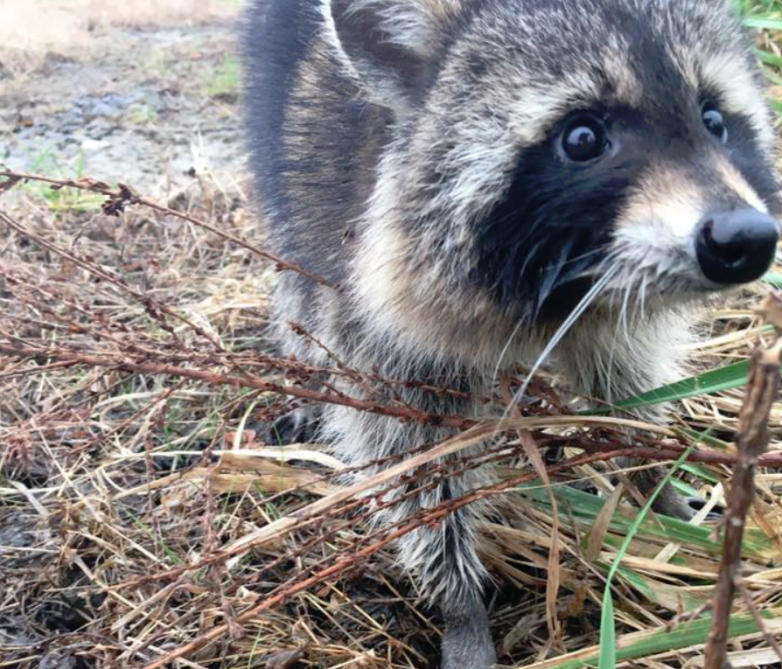

raccoon


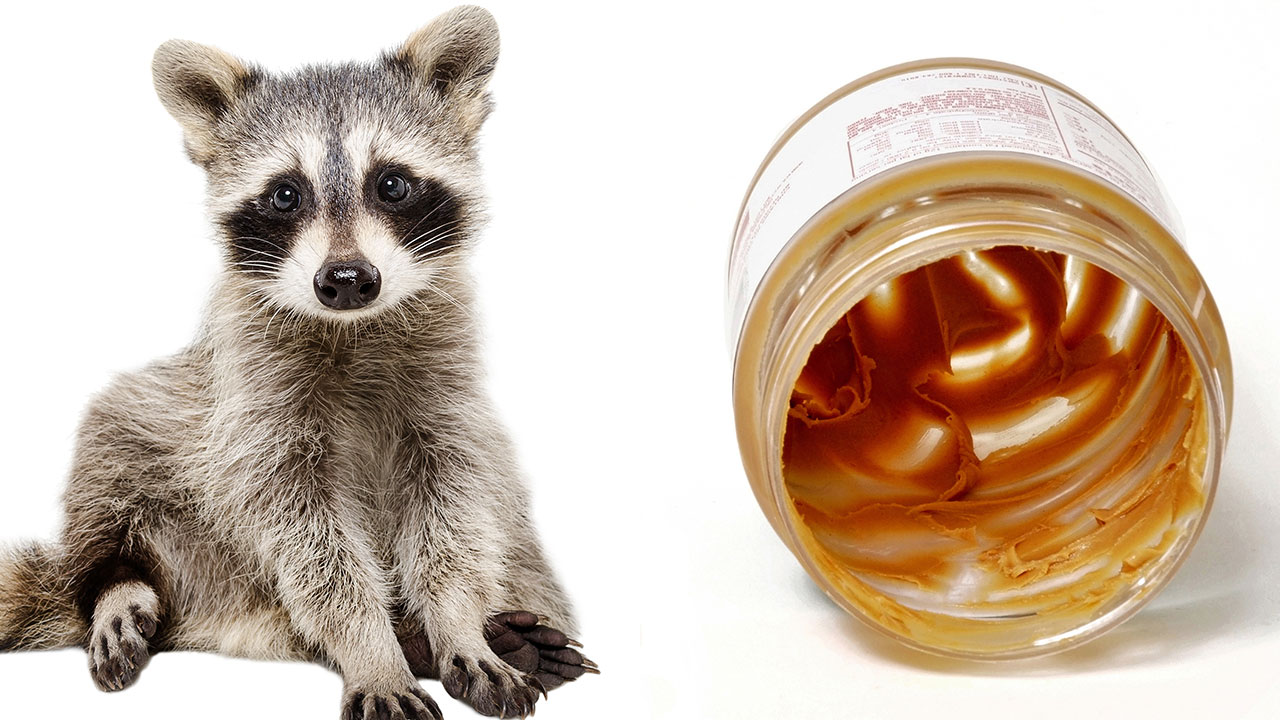

raccoon


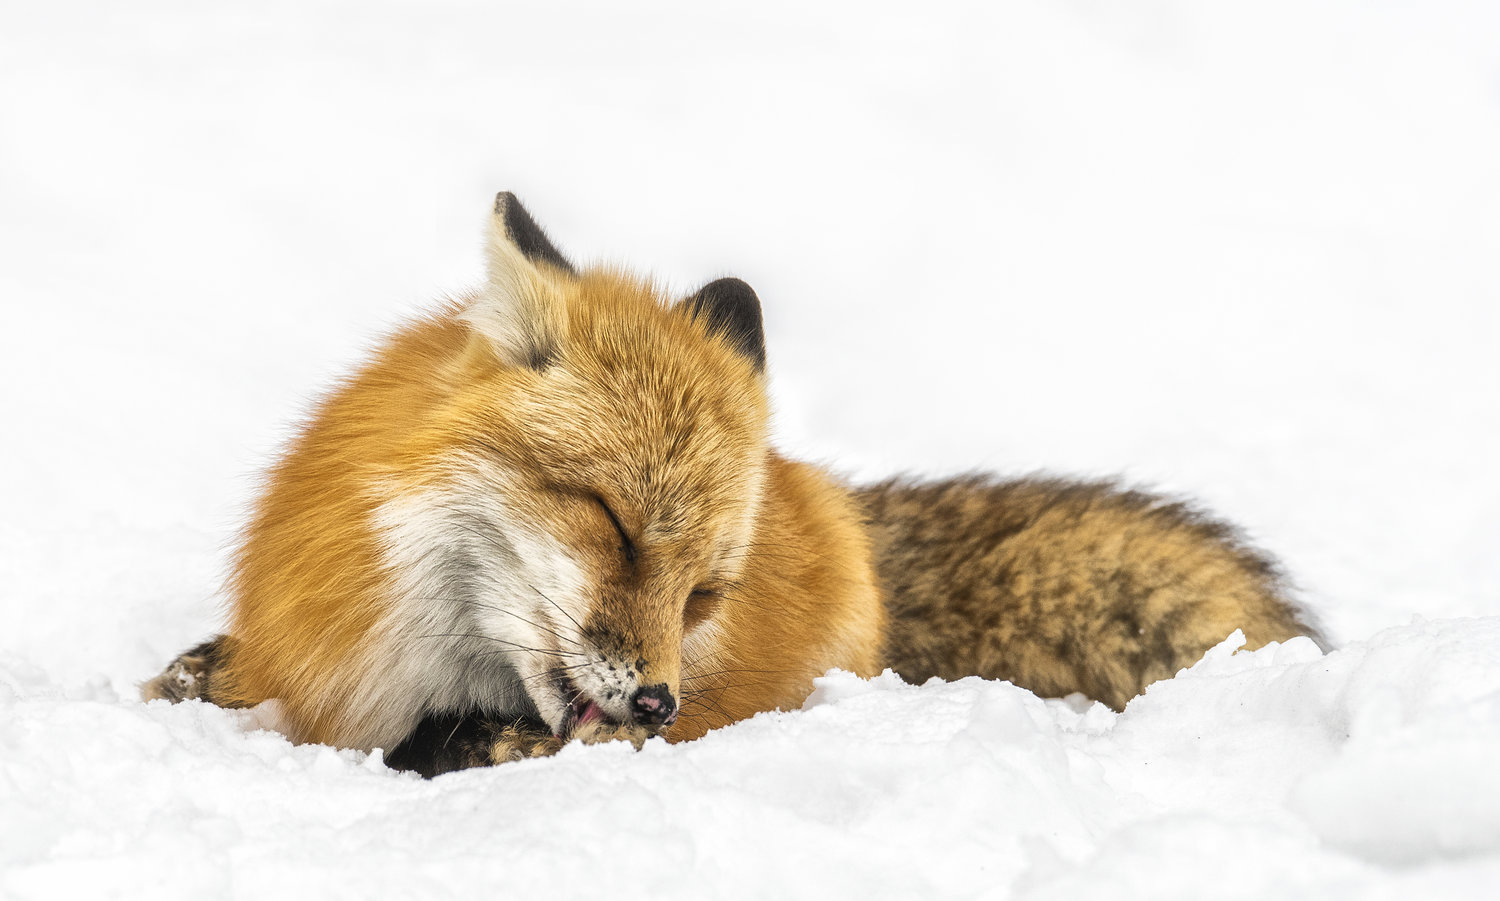

red_fox


In [6]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [7]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [8]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [9]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [8, 5, 2, 5, 0, 2, 1, 0, 1, 0]


In [10]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

training data: 5734
testing data: 1434


In [11]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [12]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [13]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, labels = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------
        
        # Reading the file        
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                labels[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [14]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    labels = rows['label'].tolist()
    return img_paths, labels

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [15]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 1

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[4.7751453e+05 1.4250171e-02]
 [4.7751453e+05 2.4229063e-02]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


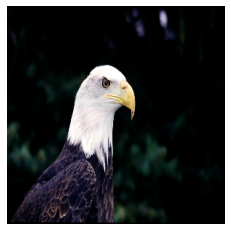

bald_eagle


In [16]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [17]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [18]:
wild_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [19]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [20]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [21]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = wild_model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def test_step(images, labels):
    predictions = wild_model(images, training=False)
    loss = loss_object(labels, predictions)

    test_loss(loss)
    test_accuracy(labels, predictions)

In [22]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.1)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            time.sleep(0.1)
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.1)
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            time.sleep(0.1)
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [23]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  477517.361353164
training:


100%|███████████████████████████████████████| 5734/5734 [22:48<00:00,  4.19it/s]

testing:



100%|███████████████████████████████████████| 1434/1434 [05:43<00:00,  4.18it/s]

Epoch 1, Loss: 4.7893, Accuracy: 11.4754, test Loss: 2.3280, test Accuracy: 9.6234
training:



100%|███████████████████████████████████████| 5734/5734 [22:54<00:00,  4.17it/s]

testing:



100%|███████████████████████████████████████| 1434/1434 [05:44<00:00,  4.16it/s]

Epoch 2, Loss: 2.9598, Accuracy: 10.3069, test Loss: 2.3195, test Accuracy: 9.6932
training:



100%|███████████████████████████████████████| 5734/5734 [22:58<00:00,  4.16it/s]

testing:



100%|███████████████████████████████████████| 1434/1434 [05:45<00:00,  4.15it/s]

Epoch 3, Loss: 2.5760, Accuracy: 10.3244, test Loss: 2.3240, test Accuracy: 9.8326
Execution time: 5154.291995882988


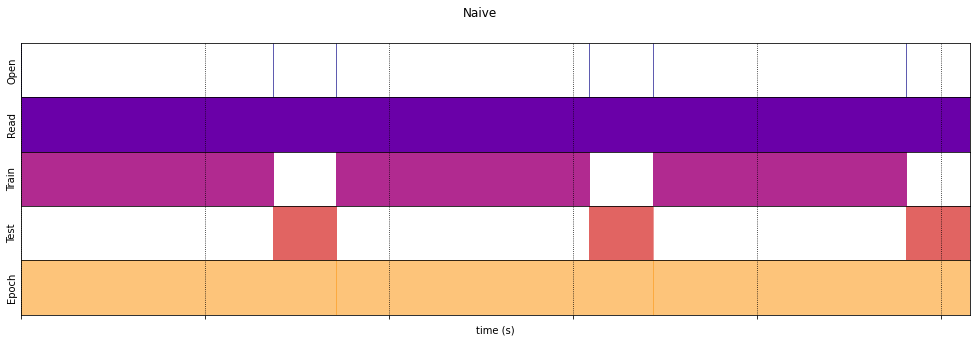

In [24]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=1)

The accuracy now is 9.83% in testing set, costing with 5154 sec. Now try some data augmentation (transformation) to observe whether the accuracy and execution time are increased or decreased.

# augmentation

In [25]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions before calling map

def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(steps.dtype, times.dtype, values.dtype, image.dtype, tf.int32)
        )
    return wrapper

@map_decorator
def map_fun_with_time(steps, times, values, image, label):
    time.sleep(0.1)
    
    # record the enter time into map_fun()
    map_enter = time.perf_counter()
    
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    distorted_image = tf.image.resize(distorted_image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    # ----------------
    
    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_with_time(steps, times, values, image, label):
    time.sleep(0.1)
    
    # record the enter time into map_fun_test()
    map_enter = time.perf_counter()
    
    distorted_image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    # ----------------
    
    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label


dataset_train_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).map(map_fun_with_time).batch(BATCH_SIZE, drop_remainder=True)
dataset_test_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).map(map_fun_test_with_time).batch(BATCH_SIZE, drop_remainder=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[b'Open']
 [b'Read']
 [b'Map']], shape=(3, 1), dtype=string) tf.Tensor(
[[4.8267328e+05 1.2072958e-02]
 [4.8267328e+05 1.1872734e-02]
 [4.8267341e+05 4.3408401e-02]], shape=(3, 2), dtype=float32) tf.Tensor(
[[ 2  0 -1]
 [ 2  0  0]
 [ 2  0  0]], shape=(3, 3), dtype=int32)
(300, 300, 3)


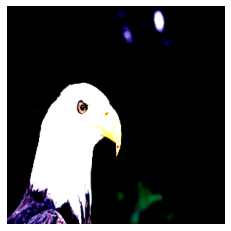

bald_eagle


In [26]:
for steps, timings, counters, img, label in dataset_train_augmentation.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [27]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3)

start time:  482674.054908514
training:


100%|███████████████████████████████████████| 5734/5734 [20:39<00:00,  4.63it/s]

testing:



100%|███████████████████████████████████████| 1434/1434 [05:10<00:00,  4.62it/s]

Epoch 1, Loss: 13.4112, Accuracy: 12.4869, test Loss: 2.3259, test Accuracy: 11.3668
training:



100%|███████████████████████████████████████| 5734/5734 [20:47<00:00,  4.60it/s]

testing:



100%|███████████████████████████████████████| 1434/1434 [05:12<00:00,  4.60it/s]

Epoch 2, Loss: 2.4617, Accuracy: 10.4813, test Loss: 2.2441, test Accuracy: 14.5049
training:



100%|███████████████████████████████████████| 5734/5734 [20:52<00:00,  4.58it/s]

testing:



100%|███████████████████████████████████████| 1434/1434 [05:13<00:00,  4.58it/s]

Epoch 3, Loss: 2.3907, Accuracy: 10.6209, test Loss: 2.3888, test Accuracy: 9.8326
Execution time: 4674.549216450949


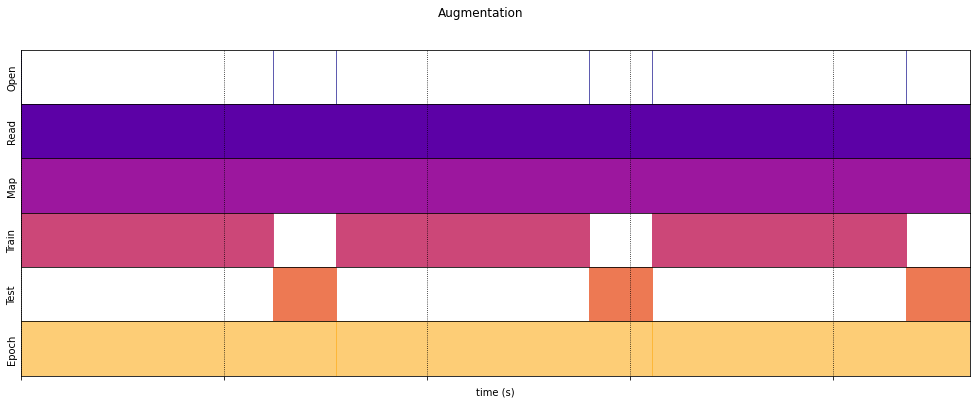

In [28]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=1)

After trying data augmentation (transformation), it's time to optimize what you did above for better efficiency.

# optimized

In [29]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated
@map_decorator
def map_fun_with_time_batchwise(steps, times, values, image, label):
    time.sleep(0.1)
    
    map_enter = time.perf_counter()
    
    # steps = np.array(steps).copy()
    # times = np.array(times).copy()
    # values = np.array(values).copy()
    # image = np.array(image).copy()
    # label = np.array(label).copy()
    
    # steps = tf.identity(steps).gpu()
    # times = tf.identity(times).gpu()
    # values = tf.identity(values).gpu()
    # image = tf.identity(image).gpu()
    # label = tf.identity(label).gpu()
    
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0],IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    # distorted_image = tf.identity(distorted_image).gpu()
    
    distorted_image = tf.image.resize(distorted_image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_with_time_batchwise(steps, times, values, image, label):   
    time.sleep(0.1)
    
    map_enter = time.perf_counter()
    
    # steps = np.array(steps).copy()
    # times = np.array(times).copy()
    # values = np.array(values).copy()
    # image = np.array(image).copy()
    # label = np.array(label).copy()
    
    # steps = tf.identity(steps).gpu()
    # times = tf.identity(times).gpu()
    # values = tf.identity(values).gpu()
    # image = tf.identity(image).gpu()
    # label = tf.identity(label).gpu()
    
    # distorted_image = tf.image.random_crop(image, [tf.shape(image)[0],IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    distorted_image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    # distorted_image = tf.identity(distorted_image).gpu()
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun_with_time_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)
dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .batch(BATCH_SIZE, drop_remainder=True)\
                                                 .map(map_fun_test_with_time_batchwise, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .cache()\
                                                 .prefetch(tf.data.AUTOTUNE)

In [30]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            # steps = np.array(steps).copy()
            # times = np.array(times).copy()
            # values = np.array(values).copy()
            # image = np.array(image).copy()
            # label = np.array(label).copy()
            
            time.sleep(0.1)
            
            # steps = tf.identity(steps).gpu()
            # times = tf.identity(times).gpu()
            # values = tf.identity(values).gpu()
            # image = tf.identity(image).gpu()
            # label = tf.identity(label).gpu()
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter
            
            time.sleep(0.1)
            
            # times = tf.identity(times).gpu()
            
            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            
            # train_time = tf.identity(train_time).gpu()
            # values = tf.identity(values).gpu()
            
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            # steps = np.array(steps).copy()
            # times = np.array(times).copy()
            # values = np.array(values).copy()
            # image = np.array(image).copy()
            # label = np.array(label).copy()
            
            time.sleep(0.1)
            
            # steps = tf.identity(steps).gpu()
            # times = tf.identity(times).gpu()
            # values = tf.identity(values).gpu()
            # image = tf.identity(image).gpu()
            # label = tf.identity(label).gpu()
            
            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter
            
            time.sleep(0.1)
            
            # times = tf.identity(times).gpu()
            
            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            
            # test_time = tf.identity(test_time).gpu()
            # times = tf.identity(times).gpu()
            # values = tf.identity(values).gpu()
            
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)
            
        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

Corrupt JPEG data: bad Huffman code
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(
[[b'Open']
 [b'Read']
 [b'Map']], shape=(3, 1), dtype=string) tf.Tensor(
[[-1.0000000e+00 -1.0000000e+00]
 [ 4.9065875e+05  3.7906109e-03]
 [ 4.9066691e+05  2.2046445e-01]], shape=(3, 2), dtype=float32) tf.Tensor(
[[   4    1   -1]
 [   4    1 5229]
 [   4    1   -1]], shape=(3, 3), dtype=int32)
(300, 300, 3)


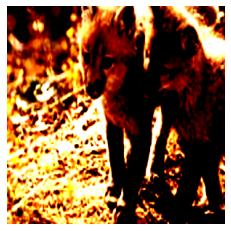

red_fox


In [32]:
for steps, timings, counters, img, label in dataset_train_optimized.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [34]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=3)

start time:  491409.561899441
training:


100%|███████████████████████████████████████| 5734/5734 [22:26<00:00,  4.26it/s]

testing:



100%|███████████████████████████████████████| 1434/1434 [05:14<00:00,  4.56it/s]

Epoch 1, Loss: 8.4656, Accuracy: 12.1556, test Loss: 2.3032, test Accuracy: 11.8550
training:



100%|███████████████████████████████████████| 5734/5734 [20:46<00:00,  4.60it/s]

testing:



100%|███████████████████████████████████████| 1434/1434 [05:11<00:00,  4.60it/s]

Epoch 2, Loss: 4.4793, Accuracy: 12.6264, test Loss: 2.3225, test Accuracy: 11.0181
training:



100%|███████████████████████████████████████| 5734/5734 [20:52<00:00,  4.58it/s]

testing:



100%|███████████████████████████████████████| 1434/1434 [05:12<00:00,  4.58it/s]

Epoch 3, Loss: 3.6265, Accuracy: 11.8242, test Loss: 2.2658, test Accuracy: 12.6918
Execution time: 4784.074548677017


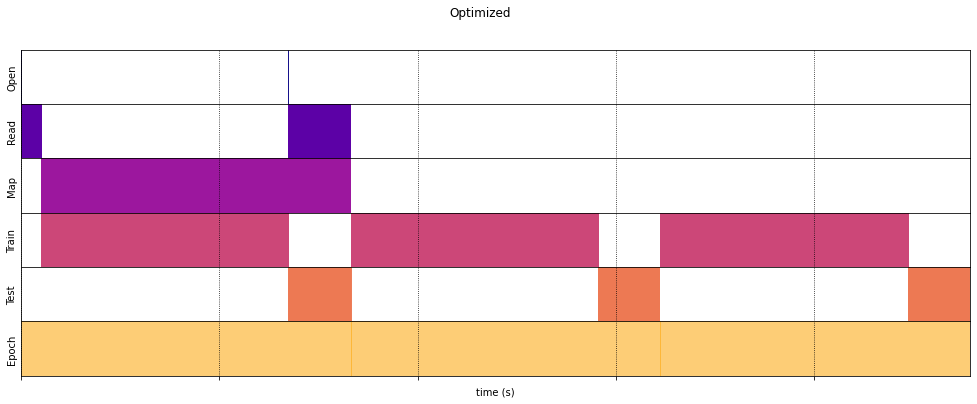

In [35]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=1)

#### This result of the answer is quite bad... There's no clear improve of test accuracy in the augmentation. Besides, the time is even longer in optimized.

# concurrency issues

In [ ]:
distorted_image = tf.image.random_crop(image, [tf.shape(image)[0],IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    /device:GPU:0}} Expected size[1] in [0, 101], but got 224 [Op:Slice]
image = tf.identity(image).gpu()
    
values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)
    device:GPU:0}} ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [196,3] vs. shape[1] = [3,3] [Op:ConcatV2] name: concat
values = tf.identity(values).gpu()
    
distorted_image = tf.image.resize(distorted_image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    device:GPU:0}} Expected begin[0] in [0, 1], but got 478365226 [Op:ResizeBilinear]
distorted_image = tf.identity(distorted_image).gpu()

values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)
    IndexError: tuple index out of range
DID NOTHING!

times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
    device:GPU:0}} ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [44,2] vs. shape[1] = [3,2] [Op:ConcatV2] name: concat
times = tf.identity(times).gpu()

times_acc = tf.concat([times_acc, train_time], axis=0)
    device:GPU:0}} ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [239,2] vs. shape[1] = [1,2] [Op:ConcatV2] name: concat
train_time = tf.identity(train_time).gpu()

tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
    device:GPU:0}} Expected multiples argument to be a vector of length 1 but got length 3 [Op:Tile]
values = tf.identity(values).gpu()

times_acc = tf.concat([times_acc, train_time], axis=0)
    /device:GPU:0}} ConcatOp : Dimension 0 in both shapes must be equal: shape[0] = [75,2] vs. shape[1] = [1,2] [Op:ConcatV2] name: concat
times = tf.identity(times).gpu()

distorted_image = tf.image.random_crop(image, [tf.shape(image)[0],IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    /device:GPU:0}} Invalid reduction dimension (56 for input with 1 dimension(s) [Op:All]